## Plant village image classification
References are mentioned at the end of the notebook

### 1) Import required libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import tensorflow
print(tensorflow.__version__)

2.4.1


In [ ]:
!nvidia-smi

Fri May 14 05:33:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

print("Loaded required libraries...")

Loaded required libraries...


### 2) Data loading and exploration

In [ ]:
fpath = "drive/MyDrive/PlantVillage"
random_seed = 111

categories = os.listdir(fpath)
print("List of categories = ",categories,"\n\nNo. of categories = ", len(categories))

List of categories =  ['Potato___healthy', 'Pepper__bell___healthy', 'Pepper__bell___Bacterial_spot', 'Tomato_Bacterial_spot', 'Potato___Early_blight', 'Tomato_healthy', 'Tomato_Early_blight', 'Potato___Late_blight', 'Tomato_Late_blight', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato_Leaf_Mold', 'Tomato__Target_Spot', 'Tomato__Tomato_mosaic_virus', 'Tomato__Tomato_YellowLeaf__Curl_Virus'] 

No. of categories =  15


In [ ]:
def load_images_and_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        for image_name in os.listdir(fpath+"/"+category)[:300]:
            file_ext = image_name.split(".")[-1]
            if (file_ext.lower() == "jpg") or (file_ext.lower() == "jpeg"):
                #print(f"\nCategory = {category}, Image name = {image_name}")
                img = cv2.imread(fpath+"/"+category+"/"+image_name)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                img_array = Image.fromarray(img, 'RGB')

                #resize image to 227 x 227 because the input image resolution for AlexNet is 227 x 227
                resized_img = img_array.resize((227, 227))

                img_lst.append(np.array(resized_img))

                labels.append(index)
    return img_lst, labels

images, labels = load_images_and_labels(categories)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))
print(type(images),type(labels))

No. of images loaded =  2252 
No. of labels loaded =  2252
<class 'list'> <class 'list'>


In [ ]:
images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

Images shape =  (2252, 227, 227, 3) 
Labels shape =  (2252,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


- Display few random images from dataset with their label

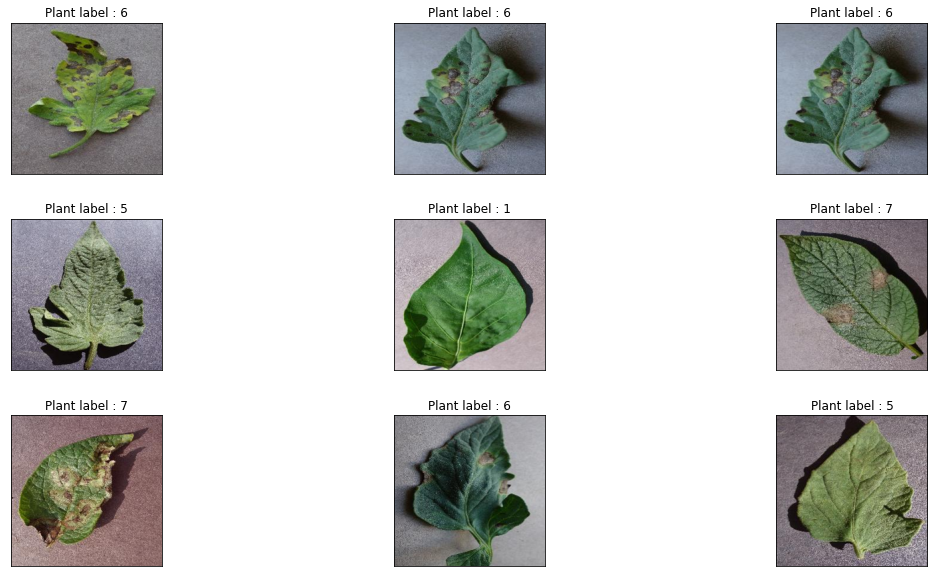

In [ ]:
def display_rand_images(images, labels):
    plt.figure(1 , figsize = (19 , 10))
    n = 0 
    for i in range(9):
        n += 1 
        r = np.random.randint(0 , images.shape[0] , 1)
        
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(images[r[0]])
        
        plt.title('Plant label : {}'.format(labels[r[0]]))
        plt.xticks([])
        plt.yticks([])
        
    plt.show()
    
display_rand_images(images, labels)

### 3) Prepare data for CNN model training
- Step 1 - shuffle the data loaded from the dataset

In [ ]:
#1-step in data shuffling

#get equally spaced numbers in a given range
n = np.arange(images.shape[0])
print("'n' values before shuffling = ",n)

#shuffle all the equally spaced values in list 'n'
np.random.seed(random_seed)
np.random.shuffle(n)
print("\n'n' values after shuffling = ",n)

'n' values before shuffling =  [   0    1    2 ... 2249 2250 2251]

'n' values after shuffling =  [ 306  941 1570 ...   86  724 2004]


In [ ]:
#2-step in data shuffling

#shuffle images and corresponding labels data in both the lists
images = images[n]
labels = labels[n]

print("Images shape after shuffling = ",images.shape,"\nLabels shape after shuffling = ",labels.shape)

Images shape after shuffling =  (2252, 227, 227, 3) 
Labels shape after shuffling =  (2252,)


In [ ]:
augment = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                             height_shift_range=0.1, shear_range=0.2, 
                             zoom_range=0.2, horizontal_flip=True, 
                             fill_mode="nearest")

- Step 2 - Data normalization

In [ ]:
images = images.astype(np.float32)
labels = labels.astype(np.int32)
images = images/255
print("Images shape after normalization = ",images.shape)

Images shape after normalization =  (2252, 227, 227, 3)


- Display few random images after normalization

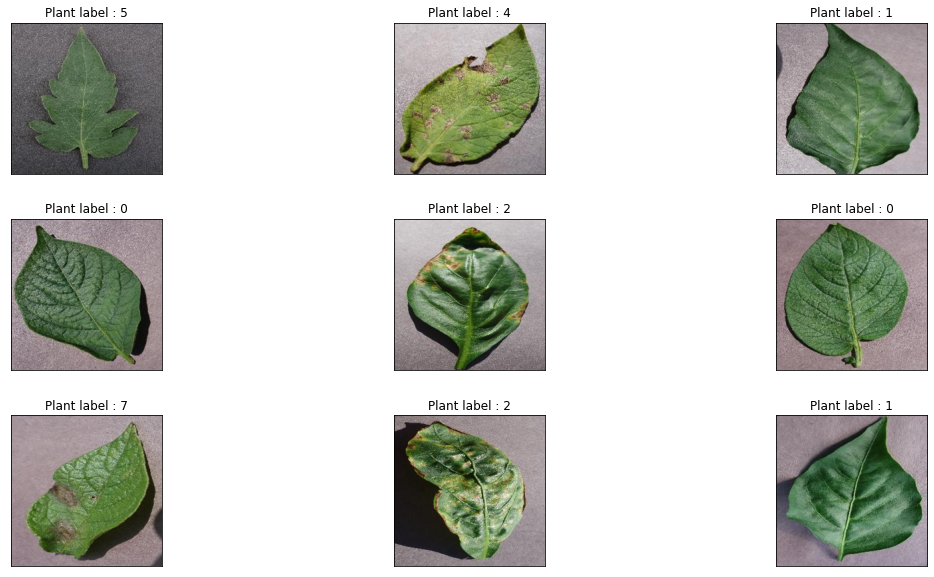

In [ ]:
display_rand_images(images, labels)

- Split dataset for training and testing

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = random_seed)

print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

x_train shape =  (1801, 227, 227, 3)
y_train shape =  (1801,)

x_test shape =  (451, 227, 227, 3)
y_test shape =  (451,)


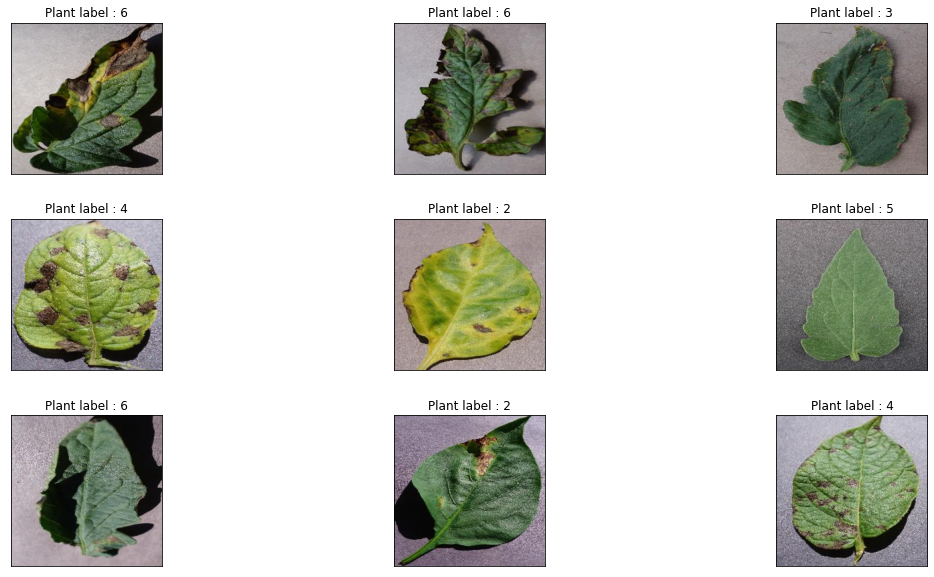

In [ ]:
display_rand_images(x_train, y_train)

### 4) Define CNN model (AlexNet)

In [ ]:
model=Sequential()

#1 conv layer
model.add(Conv2D(filters=96,kernel_size=(11,11),strides=(4,4),padding="valid",activation="relu",input_shape=(227,227,3)))

#1 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(BatchNormalization())

#2 conv layer
model.add(Conv2D(filters=256,kernel_size=(5,5),strides=(1,1),padding="valid",activation="relu"))

#2 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(BatchNormalization())

#3 conv layer
model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#4 conv layer
model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#5 conv layer
model.add(Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#3 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(BatchNormalization())


model.add(Flatten())

#1 dense layer
model.add(Dense(4096,input_shape=(227,227,3),activation="relu"))

model.add(Dropout(0.4))

model.add(BatchNormalization())

#2 dense layer
model.add(Dense(4096,activation="relu"))

model.add(Dropout(0.4))

model.add(BatchNormalization())

#3 dense layer
model.add(Dense(1000,activation="relu"))

model.add(Dropout(0.4))

model.add(BatchNormalization())

#output layer
model.add(Dense(20,activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 23, 23, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 256)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 256)       1024      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 384)         8

- Compile the defined CNN model

In [ ]:
EPOCHS = 100
LR = 1e-3
BATCH_SIZE = 32

In [ ]:
opt = Adam(lr=LR, decay=LR / EPOCHS)

In [ ]:
model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

### 5) Train the model

- Fit the model using training data

In [ ]:
history = model.fit(augment.flow(x_train, y_train, batch_size=BATCH_SIZE),
                    validation_data=(x_test, y_test),
                    steps_per_epoch=len(x_train) // BATCH_SIZE,
                    epochs = 200
                    )

Epoch 1/200
56/56 [==============================] - 19s 345ms/step - loss: 0.1754 - accuracy: 0.9457 - val_loss: 0.5818 - val_accuracy: 0.8537
Epoch 2/200
56/56 [==============================] - 19s 337ms/step - loss: 0.1301 - accuracy: 0.9531 - val_loss: 0.1515 - val_accuracy: 0.9579
Epoch 3/200
56/56 [==============================] - 19s 338ms/step - loss: 0.0945 - accuracy: 0.9650 - val_loss: 0.6479 - val_accuracy: 0.8271
Epoch 4/200
56/56 [==============================] - 19s 348ms/step - loss: 0.1204 - accuracy: 0.9604 - val_loss: 4.0817 - val_accuracy: 0.5188
Epoch 5/200
56/56 [==============================] - 19s 343ms/step - loss: 0.1221 - accuracy: 0.9553 - val_loss: 1.0714 - val_accuracy: 0.7716
Epoch 6/200
56/56 [==============================] - 19s 342ms/step - loss: 0.1234 - accuracy: 0.9593 - val_loss: 0.1858 - val_accuracy: 0.9468
Epoch 7/200
56/56 [==============================] - 19s 343ms/step - loss: 0.1142 - accuracy: 0.9650 - val_loss: 0.0702 - val_accuracy:

### 6) Predicting values using trained model

In [ ]:
pred = model.predict(x_test)

pred.shape

(451, 20)

- Display few random images with actual vs predicted values of labels

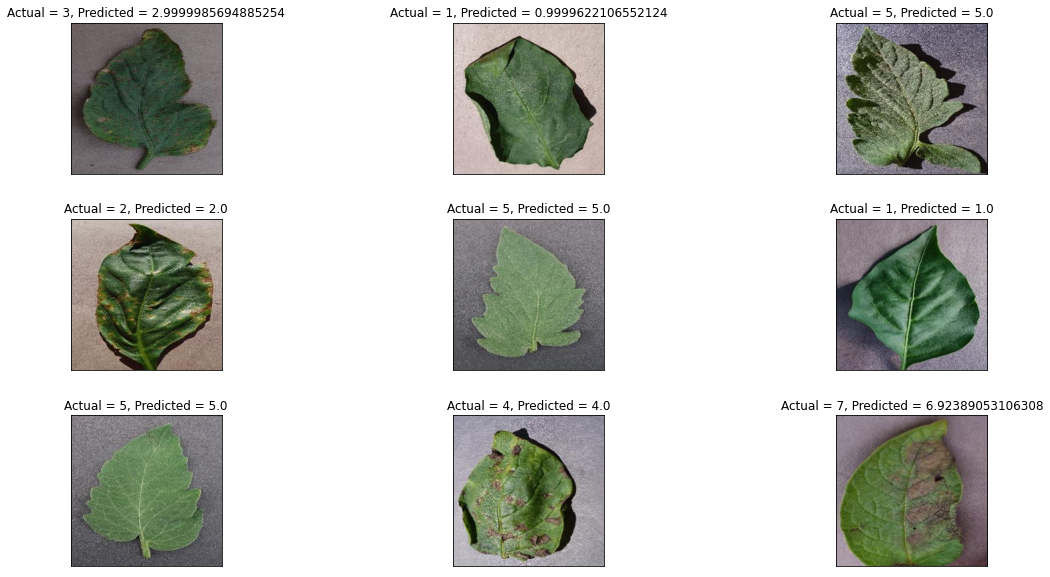

In [ ]:
plt.figure(1 , figsize = (19 , 10))
n = 0 

for i in range(9):
    n += 1 
    r = np.random.randint( 0, x_test.shape[0], 1)
    
    plt.subplot(3, 3, n)
    plt.subplots_adjust(hspace = 0.3, wspace = 0.3)
    
    plt.imshow(x_test[r[0]])
    plt.title('Actual = {}, Predicted = {}'.format(y_test[r[0]] , y_test[r[0]]*pred[r[0]][y_test[r[0]]]) )
    plt.xticks([]) , plt.yticks([])

plt.show()

### 7) Save trained model, weights

In [ ]:
!pip install tensorflowjs 

     |████████████████████████████████| 71kB 5.3MB/s 
     |████████████████████████████████| 112kB 13.5MB/s 
  Found existing installation: tensorflow-hub 0.12.0
    Uninstalling tensorflow-hub-0.12.0:
      Successfully uninstalled tensorflow-hub-0.12.0


In [ ]:
model.save('model_alexnet_epoch200.h5')

In [ ]:
!mkdir model_alexnet
!tensorflowjs_converter --input_format keras model_alexnet_epoch200.h5 model/

2021-05-13 15:10:40.274088: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [ ]:
!zip -r model.zip model 

  adding: model/ (stored 0%)
  adding: model/group1-shard17of28.bin (deflated 7%)
  adding: model/group1-shard19of28.bin (deflated 7%)
  adding: model/group1-shard2of28.bin (deflated 7%)
  adding: model/group1-shard12of28.bin (deflated 7%)
  adding: model/group1-shard4of28.bin (deflated 7%)
  adding: model/group1-shard25of28.bin (deflated 7%)
  adding: model/group1-shard27of28.bin (deflated 7%)
  adding: model/group1-shard15of28.bin (deflated 7%)
  adding: model/group1-shard22of28.bin (deflated 7%)
  adding: model/group1-shard9of28.bin (deflated 7%)
  adding: model/group1-shard23of28.bin (deflated 7%)
  adding: model/group1-shard13of28.bin (deflated 7%)
  adding: model/group1-shard21of28.bin (deflated 7%)
  adding: model/group1-shard16of28.bin (deflated 7%)
  adding: model/group1-shard26of28.bin (deflated 7%)
  adding: model/model.json (deflated 90%)
  adding: model/group1-shard28of28.bin (deflated 7%)
  adding: model/group1-shard3of28.bin (deflated 7%)
  adding: model/group1-shard20of

In [ ]:
from google.colab import files
files.download('model.zip')